<a href="https://colab.research.google.com/github/valmirf/redes_neurais_ple/blob/master/SOM/Self_Organizing_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/valmirf/redes_neurais_ple.git

Cloning into 'redes_neurais_ple'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 75 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.


# Self-Organising Maps Network

Segue um código exemplo da rede neural SOM

Para maiores detalhes ver site:
http://blog.yhat.com/posts/self-organizing-maps-2.html

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

Configuração da SOM

Escolhe:
1. Tamanho do mapa da SOM: X e Y
2. Número de iterações
3. Taxa de aprendizado
4. Tipo de normalização dos dados


In [23]:
X = 5
Y = 5
network_dimensions = np.array([X, Y])
label_map = np.zeros((X,Y,3))

n_iterations = 10000
init_learning_rate = 0.1

normalize_data = True

# if True, assume all data on common scale
# if False, normalize to [0 1] range along each column
normalize_by_column = False

Cria base com dados aleatórios em 3 classes

In [66]:
# Neste código vou utilizar o pandas, framework amplamente utilizado pra lidar com dados
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#carrega a base de dados e retorna conjuntos de treinamento e teste
def load_data():
    url = 'redes_neurais_ple/RBF/iris.csv'
    df = pd.read_csv(url,  header=None)
    #remove a ultima coluna (dados)
    data = df[df.columns[:-1]]
    print(data)    
    #retorna a última coluna (rótulos)
    labels = df[df.columns[-1]]

    return data, labels

In [68]:
local = 'redes_neurais/SOM/iris.csv'

#number of columns of your file
num_cols = 4

raw_data,labels = load_data()

# establish variables based on data
m = raw_data.shape[1]
n = raw_data.shape[0]

#transforma rótulos do conjunto de treinamento em numeros pra calculo do erro
le = preprocessing.LabelEncoder()
le.fit(labels.values)
training_labels_transformed = le.transform(labels.values)
c = le.classes_


data = raw_data
# check if data needs to be normalised
if normalize_data:
    if normalize_by_column:
        # normalise along each column
        col_maxes = data.max(axis=0)
        normalized_data = (data - col_maxes.min()) / (col_maxes.max() - col_maxes.min())
    else:
        # normalise entire dataset
        normalized_data = (data - data.min()) / (data.max() - data.min())


       0    1    2    3
0    5.1  3.5  1.4  0.2
1    4.9  3.0  1.4  0.2
2    4.7  3.2  1.3  0.2
3    4.6  3.1  1.5  0.2
4    5.0  3.6  1.4  0.2
..   ...  ...  ...  ...
145  6.7  3.0  5.2  2.3
146  6.3  2.5  5.0  1.9
147  6.5  3.0  5.2  2.0
148  6.2  3.4  5.4  2.3
149  5.9  3.0  5.1  1.8

[150 rows x 4 columns]


In [39]:
#cria raio inicial de acordo com o tamanho inicial do mapa da SOM
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2

#constante de tempo que decai com o tempo
time_constant = n_iterations / np.log(init_radius)

# inicialização dos pesos m=dimensional pra cada neurônio da matriz SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

Rede Neural SOM

In [40]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    #print('bmu: ', bmu)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [41]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [42]:
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [43]:
#neighborhood
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

Aprendizado SOM

Etapa 0: posicione aleatoriamente os neurônios no mapa da rede SOM.

Etapa 1: selecione um exemplo da base de dados, aleatoriamente ou sistematicamente no conjunto de dados

Etapa 2: encontre o neurônio mais próximo do ponto de dados escolhido. Esse neurônio é chamado de Unidade de Melhor Similaridade (BMU - Best Unit Matching).

Etapa 3: Mova a BMU para mais perto desse ponto de dados. A distância movida pela BMU é determinada por uma taxa de aprendizado, que diminui após cada iteração.

Etapa 4: aproxime também os vizinhos da BMU desse ponto de dados, com os vizinhos mais distantes se movendo menos. Os vizinhos são identificados usando um raio ao redor da BMU, e o valor desse raio diminui após cada iteração.

Etapa 5: atualize a taxa de aprendizado e o raio da BMU, antes de repetir as etapas 1 a 4. Repita essas etapas até que as posições dos neurônios tenham sido estabilizadas.

In [79]:
for i in range(n_iterations):
    
    #print('Iteration %d' % i)
    
    #seleciona um exemplo aleatoriamente da base de dados
    random_example = np.random.randint(0, n)
    t = data.iloc[random_example].values.reshape(np.array([m, 1]))
  
    #calcula neurônio mais próximo a este exemplo (BMU)
    bmu, bmu_idx = find_bmu(t, net, m)
    
    #seleciona a classe do exemplo (Apenas pra vias de informação no mapa)
    class_index = list(c).index(labels[random_example])
    
    lab = label_map[bmu_idx[0],bmu_idx[1]]  
    lab[class_index] = lab[class_index]+1
    #associa o neurônio a esta classe
    label_map[bmu_idx[0],bmu_idx[1]] = lab
    #print('label_map:', label_map[bmu_idx[0],bmu_idx[1]])                                              
    # Decresce os parâmetros da SOM
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # Atualiza o vetor de Pesos da rede SOM para todos os neurônios da rede
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # calcula a distância do neurônio ao neurônio vencedor
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # se distância está dentro do raio estipulado r^2
            if w_dist <= r**2:
                # calcula a função de vizinhança
                influence = calculate_influence(w_dist, r)
                # atualiza os pesos
                # w(t+1) = w(t) + (learning rate * h * distancia)
                new_w = w + (l * influence * (t - w))
                # coloca o novo peso na rede na posição X,Y
                net[x, y, :] = new_w.reshape(1, m)

Visualiza o mapa criado

ValueError: ignored

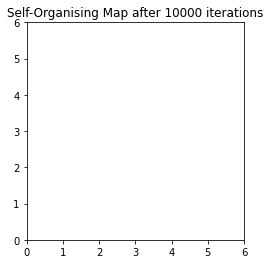

In [80]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

#get class name

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        m = label_map[x-1,y-1]
        name_class = c[np.argmax(m)]
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none',label='sdsad'))
        ax.text(x,y, name_class,
         horizontalalignment='center', verticalalignment='center',
         fontsize=7, color='red')
plt.show()

#EXEMPLO COM BIBLIOTECA SOMCLU

Essa biblioteca suporta uso de GPUs e possui implementação super simples

In [ ]:
!pip install somoclu
!pip install ipython ipdb

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import somoclu
import ipdb
%matplotlib inline


     |████████████████████████████████| 6.2MB 2.8MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5-cp36-cp36m-linux_x86_64.whl size=420993 sha256=014c2651c786737d18d645c4cdedda1e1e4552828a6a4a719d6b2f93359e9728
  Stored in directory: /root/.cache/pip/wheels/85/3c/e5/5b1c535e93453367a8e3d35a377d3c668da00369b1a4302ad8
Successfully built somoclu
  Created wheel for ipdb: filename=ipdb-0.13.2-cp36-none-any.whl size=10522 sha256=3051ad7953e1f094a5db9de2ea79d2bde3bc5c488f6605e918926dbf4829d6cf
  Stored in directory: /root/.cache/pip/wheels/60/c2/15/793365e3c9318c46ba914263740d90f1fe67f544b979141ce4
Successfully built ipdb


Exemplo com a base de dados Iris

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/art3d.py:772: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/art3d.py:774: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


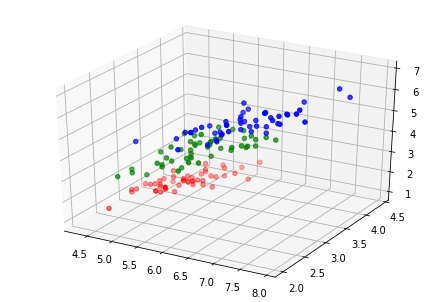

In [ ]:
local = 'redes_neurais/SOM/iris.csv'
c1 = np.genfromtxt(local, delimiter=',', usecols=(0, 1, 2, 3), max_rows = 50) 
c2 = np.genfromtxt(local, delimiter=',', usecols=(0, 1, 2, 3),skip_header = 50, max_rows = 50)
c3 = np.genfromtxt(local, delimiter=',', usecols=(0, 1, 2, 3),skip_header=100, max_rows = 50)
data = np.float32(np.concatenate((c1, c2, c3)))
 
colors = ["red"] * 50
colors.extend(["green"] * 50)
colors.extend(["blue"] * 50)
#colors.extend(["yellow"] * 50)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], data[:, 3], c=colors)
labels = range(150)

Executando a rede neural SOM

In [ ]:
#escolha o tamanho da rede SOM
n_rows, n_columns = 100, 160
som = somoclu.Somoclu(n_columns, n_rows, data=data)
%time som.train()

CPU times: user 15 s, sys: 21.3 ms, total: 15.1 s
Wall time: 7.61 s


Visualizar o resultado:

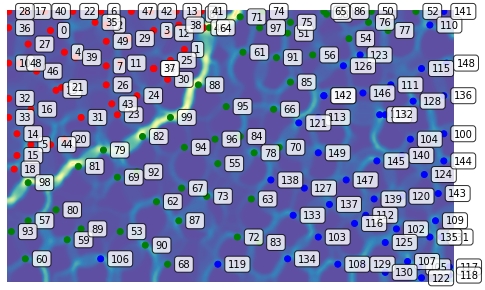

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)

#Mini-Projeto 2:

Execute a Redes Neurais SOM acima com a base de dados MNist que possui caracteres de 0 a 9. Mostre os resultados abaixo:

1. Mostre 5 configurações de mapa diferentes
2. Escolha uma vizinhança diferente da padrão (Ver Slide 16). Construa os mesmos 5 mapas da questão anterior.
3. Utilize um índice para avaliação de algoritmos não supervisionados para avaliar os resultados dos mapas. (Ex: Índice de Rand, índice de Hartigan, F-Measure, Jaccard, Índice de Rand)

Ver artigo: Evaluation Metrics for Unsupervised Learning
Algorithms na pasta da rede SOM do github.

DATA DE ENTREGA: 06/04/2020


